# Energy Analysis Case - Regression ML Classification

## OUTLINE: 

- Open the dataset
- Explore the dataset
  - Make sure that there are no missing values
  - Make sure that there are no erroneous values (e.g. words where only numbers should be)
- Split the data in train and test sets
- Scale the data
- Train two regression models on the data
- Compare the performance of the two models on the test data

### *Library Install*

In [1]:
# Import the basic libraries: pandas, matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from ucimlrepo import fetch_ucirepo 

from sklearn.model_selection import RepeatedKFold, cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import make_scorer, mean_absolute_error

RSEED=8

### Dataset description:
The dataset that we will be using comes from the [UCI repository](https://archive.ics.uci.edu/dataset/242/energy+efficiency). <br>

This study looked into assessing the heating load and cooling load requirements of buildings (that is, energy efficiency) as a function of building parameters. They perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. Therefore, it produces the dataset which comprises 768 samples and 8 features, aiming to predict two real valued responses.

The dataset contains eight attributes (or features, denoted by X1...X8) and two responses (or outcomes, denoted by y1 and y2). The aim is to use the eight features to predict each of the two responses.

Specifically: <br>
- X1	Relative Compactness <br>
- X2	Surface Area <br>
- X3	Wall Area <br>
- X4	Roof Area <br>
- X5	Overall Height <br>
- X6	Orientation <br>
- X7	Glazing Area <br>
- X8	Glazing Area Distribution <br>
- y1	Heating Load <br>
- y2	Cooling Load <br>

### *Reading the file*

In [2]:
# fetch dataset 
energy_efficiency = fetch_ucirepo(id=242) 
  
# data (as pandas dataframes) 
X = energy_efficiency.data.features 
y = energy_efficiency.data.targets 
  
# metadata 
print(energy_efficiency.metadata) 
  
# variable information 
print(energy_efficiency.variables) 


# Another option is to download the dataset manually on https://archive.ics.uci.edu/dataset/242/energy+efficiency

{'uci_id': 242, 'name': 'Energy Efficiency', 'repository_url': 'https://archive.ics.uci.edu/dataset/242/energy+efficiency', 'data_url': 'https://archive.ics.uci.edu/static/public/242/data.csv', 'abstract': 'This study looked into assessing the heating load and cooling load requirements of buildings (that is, energy efficiency) as a function of building parameters.', 'area': 'Computer Science', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 768, 'num_features': 8, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Y1', 'Y2'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2012, 'last_updated': 'Mon Feb 26 2024', 'dataset_doi': '10.24432/C51307', 'creators': ['Athanasios Tsanas', 'Angeliki Xifara'], 'intro_paper': {'ID': 379, 'type': 'NATIVE', 'title': 'Accurate quantitative estimation of energy performance of residential buildings using statistical machine 

In [3]:
# Check the data types for each column
X.dtypes

X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6      int64
X7    float64
X8      int64
dtype: object

In [4]:
y.dtypes

Y1    float64
Y2    float64
dtype: object

In [5]:
X.rename(columns={"X1":"Relative_Compactness", 
                "X2":"Surface_Area",
                "X3":"Wall_Area",
                "X4":"Roof_Area",
                "X5":"Overall_Height",
                "X6":"Orientation",
                "X7":"Glazing_Area",
                "X8":"Glazing_Area_Distribution",
}, inplace=True)

C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_18748\513983923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns={"X1":"Relative_Compactness",


In [6]:
# Describe the dataset
X.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000


In [7]:
y.rename(columns={"Y1":"Heating_Load",
                "Y2":"Cooling_Load"},
                inplace=True)

C:\Users\ignasius.dwi\AppData\Local\Temp\ipykernel_18748\2613507644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.rename(columns={"Y1":"Heating_Load",


### *Train-test split* 

Since this is a regression, stratification is not trivial. As of now, it's just random.


In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

In [9]:
# Print the average heating load for the training set and the testing set
print(y_train['Heating_Load'].mean())
print(y_test['Heating_Load'].mean())

22.228811074918568
22.61974025974026


In [10]:
# Print the average cooling load for the training set and the testing set
print(y_train['Cooling_Load'].mean())
print(y_test['Cooling_Load'].mean())

24.485781758957657
24.99435064935065


> Observation:
We did not stratify, but we were lucky enough: heating and cooling load have a similar mean in the training and test set.

#### *EDA*

Text(0, 0.5, 'Frequency')

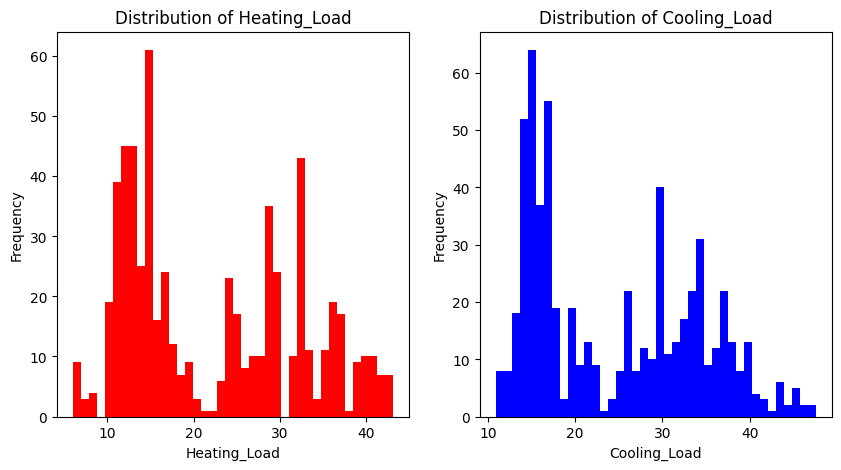

In [11]:
# Create two barplots to show the distribution of the target variables
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train['Heating_Load'], bins=40, color='red')
plt.title('Distribution of Heating_Load')
plt.xlabel('Heating_Load')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(y_train['Cooling_Load'], bins=40, color='blue')
plt.title('Distribution of Cooling_Load')
plt.xlabel('Cooling_Load')
plt.ylabel('Frequency')


In [12]:
# Print the minimum, maximum and interquartile ranges values of y_train['Heating_Load'] and y_train['Cooling_Load']
print("-"*50)
print("Heating_Load min: ",y_train['Heating_Load'].min())
print("Heating_Load max: ",y_train['Heating_Load'].max())
print("Heating_Load Q1: ",y_train['Heating_Load'].quantile(0.25))
print("Heating_Load Q2: ",y_train['Heating_Load'].quantile(0.75))
print("="*50)
print("Cooling_Load min: ",y_train['Cooling_Load'].min())
print("Cooling_Load max: ",y_train['Cooling_Load'].max())
print("Cooling_Load Q1: ",y_train['Cooling_Load'].quantile(0.25))
print("Cooling_Load Q2: ",y_train['Cooling_Load'].quantile(0.75))
print("-"*50)

--------------------------------------------------
Heating_Load min:  6.01
Heating_Load max:  43.1
Heating_Load Q1:  13.0
Heating_Load Q2:  31.655
Cooling_Load min:  10.9
Cooling_Load max:  47.59
Cooling_Load Q1:  15.5375
Cooling_Load Q2:  32.9275
--------------------------------------------------


Text(0, 0.5, 'Heating Load')

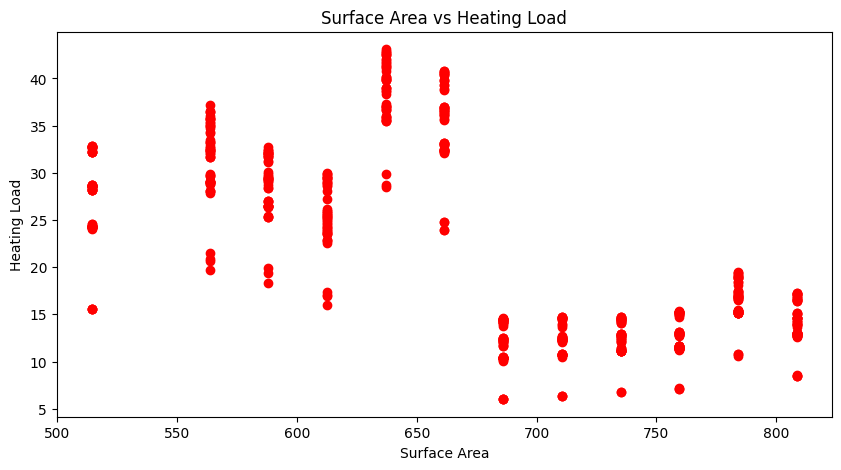

In [13]:
# Create a scatterplot to show the relationship between the surface area and the heating load
plt.figure(figsize=(10, 5))
plt.scatter(X_train['Surface_Area'], y_train['Heating_Load'], color='red')
plt.title('Surface Area vs Heating Load')
plt.xlabel('Surface Area')
plt.ylabel('Heating Load')

Text(0, 0.5, 'Heating Load')

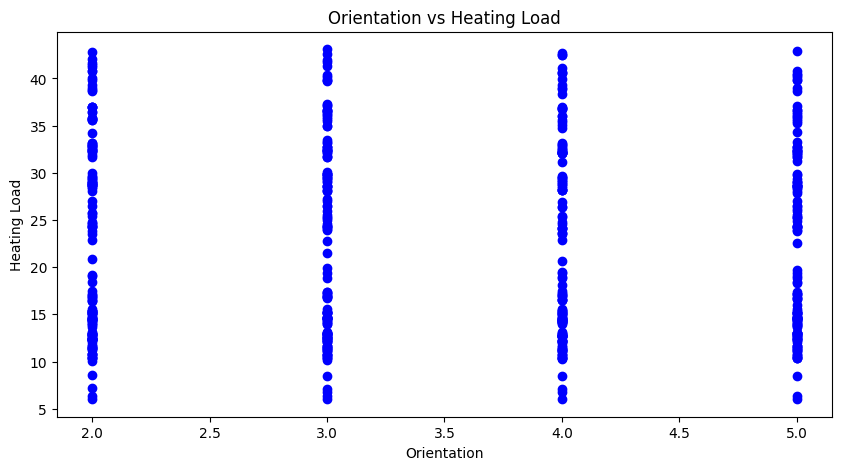

In [14]:
# Create a scatterplot to show the relationship between the orientation and the heating load
plt.figure(figsize=(10, 5))
plt.scatter(X_train['Orientation'], y_train['Heating_Load'], color='blue')
plt.title('Orientation vs Heating Load')
plt.xlabel('Orientation')
plt.ylabel('Heating Load')

#### *Preprocessing*

> Observation:
The range of values for the surface area goes from a minimum of 500 to a maximum of 800 (square feet). The height goes from 3.5 to 7. Since the range between variable are too far, standardization helps to avoid the negative impact of having features with different ranges.

In [15]:
# Select the numerical features
numerical_features = ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Glazing_Area']

In [16]:
# standardize the features of the dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
# select the numerical features from the training set
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [17]:
X_train.head()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution
610,-0.702246,0.717396,-0.556510,0.972971,-1.0,4,1.247897,2
151,1.263188,-1.212121,-0.004495,-1.182750,1.0,5,-1.001248,3
464,-0.702246,0.717396,-0.556510,0.972971,-1.0,2,0.123324,4
5,1.263188,-1.212121,-0.004495,-1.182750,1.0,3,-1.750963,0
674,2.011925,-1.763412,-0.556510,-1.452215,1.0,4,1.247897,4


Text(0, 0.5, 'Heating Load')

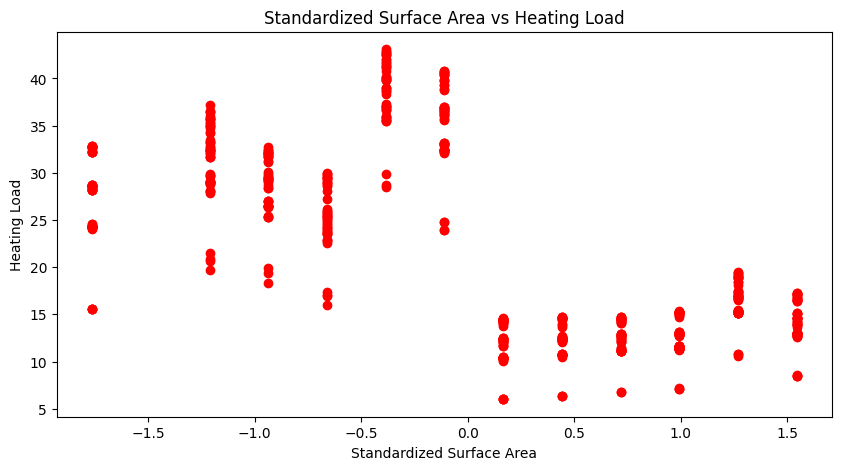

In [18]:
# Create a scatterplot to show the relationship between the Standardized Surface Area and the heating load
plt.figure(figsize=(10, 5))
plt.scatter(X_train['Surface_Area'], y_train['Heating_Load'], color='red')
plt.title('Standardized Surface Area vs Heating Load')
plt.xlabel('Standardized Surface Area')
plt.ylabel('Heating Load')

#### *Regression*

For evaluation purposes, we use *cross_validate* to collect multiple metrics at once.

In [19]:
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error'
}

>In this case, we train separate models for Heating_Load and Cooling_Load output. The advantage of this approach is to get different best hyperparameter per target.

In [20]:
# Train a linear regression model, using 5 fold cross validation. The score is the negative root mean squared error.

from sklearn.linear_model import LinearRegression

target = ["Cooling_Load","Heating_Load"]
results_multi = {}
for i in target:
    regressor = LinearRegression()
    regressor.fit(X_train, y_train[i])
    scores = cross_validate(regressor, X_train, y_train[i], cv=5, scoring=scoring)
    x_val = pd.DataFrame(scores)
    print(i)
    print("-"*50)
    print(x_val)
    print('-'*50)
    print("Mean")
    print(x_val.mean())
    print('='*50)

Cooling_Load
--------------------------------------------------
   fit_time  score_time  test_MAE   test_R2  test_RMSE
0     0.000    0.007996 -2.169809  0.886830  -3.062547
1     0.000    0.000000 -2.391886  0.882712  -3.282634
2     0.000    0.000000 -2.178355  0.901348  -3.020087
3     0.008    0.000000 -2.172980  0.881153  -3.159903
4     0.000    0.008032 -2.275280  0.874773  -3.374401
--------------------------------------------------
Mean
fit_time      0.001600
score_time    0.003205
test_MAE     -2.237662
test_R2       0.885363
test_RMSE    -3.179914
dtype: float64
Heating_Load
--------------------------------------------------
   fit_time  score_time  test_MAE   test_R2  test_RMSE
0  0.000000    0.008011 -2.104240  0.908188  -2.948084
1  0.000000    0.000000 -2.044276  0.914886  -2.869692
2  0.007988    0.000000 -2.166271  0.908008  -3.141979
3  0.000000    0.000000 -2.070251  0.915833  -2.939219
4  0.000000    0.008008 -2.093169  0.915503  -2.881697
--------------------------

In [21]:
# train a random lasso regression model, using 5 fold cross validation.

from sklearn.linear_model import Lasso

target = ["Cooling_Load","Heating_Load"]
results_multi = {}
for i in target:
    regressor2 = Lasso()
    regressor2.fit(X_train, y_train[i])
    scores2 = cross_validate(regressor2, X_train, y_train['Heating_Load'], cv=5, scoring=scoring)
    x_val2 = pd.DataFrame(scores2)
    print(i)
    print("-"*50)
    print(x_val2)
    print("-"*50)
    print("Mean")
    print(x_val2.mean())
    print('='*50)

Cooling_Load
--------------------------------------------------
   fit_time  score_time  test_MAE   test_R2  test_RMSE
0  0.000000         0.0 -2.516018  0.873940  -3.454441
1  0.000000         0.0 -2.336855  0.892458  -3.225694
2  0.007996         0.0 -2.749284  0.859545  -3.882367
3  0.000000         0.0 -2.458176  0.892494  -3.321828
4  0.007969         0.0 -2.490832  0.882822  -3.393527
--------------------------------------------------
Mean
fit_time      0.003193
score_time    0.000000
test_MAE     -2.510233
test_R2       0.880252
test_RMSE    -3.455571
dtype: float64
Heating_Load
--------------------------------------------------
   fit_time  score_time  test_MAE   test_R2  test_RMSE
0  0.000000    0.000000 -2.516018  0.873940  -3.454441
1  0.000000    0.008003 -2.336855  0.892458  -3.225694
2  0.000000    0.000000 -2.749284  0.859545  -3.882367
3  0.008031    0.000000 -2.458176  0.892494  -3.321828
4  0.000000    0.000000 -2.490832  0.882822  -3.393527
--------------------------

In [22]:
# train a ridge regression model, using 5 fold cross validation.

from sklearn.linear_model import Ridge

regressor3 = Ridge()
target = ["Cooling_Load","Heating_Load"]
results_multi = {}
for i in target:
    regressor3.fit(X_train, y_train[i])
    scores3 = cross_validate(regressor3, X_train, y_train['Heating_Load'], cv=5, scoring=scoring)
    x_val3 = pd.DataFrame(scores3)
    print(i)
    print("-"*50)
    print(x_val3)
    print("-"*50)
    print("Mean")
    print(x_val3.mean())
    print('='*50)

Cooling_Load
--------------------------------------------------
   fit_time  score_time  test_MAE   test_R2  test_RMSE
0       0.0    0.000000 -2.094941  0.908526  -2.942647
1       0.0    0.007999 -2.051366  0.914546  -2.875416
2       0.0    0.000000 -2.158263  0.907016  -3.158875
3       0.0    0.007999 -2.017181  0.917513  -2.909740
4       0.0    0.000000 -2.118291  0.914680  -2.895704
--------------------------------------------------
Mean
fit_time      0.000000
score_time    0.003200
test_MAE     -2.088008
test_R2       0.912456
test_RMSE    -2.956476
dtype: float64
Heating_Load
--------------------------------------------------
   fit_time  score_time  test_MAE   test_R2  test_RMSE
0  0.000000    0.007963 -2.094941  0.908526  -2.942647
1  0.000000    0.000000 -2.051366  0.914546  -2.875416
2  0.000000    0.007998 -2.158263  0.907016  -3.158875
3  0.000000    0.000000 -2.017181  0.917513  -2.909740
4  0.008002    0.000000 -2.118291  0.914680  -2.895704
--------------------------

For simplification, we only display "Heating_Load" output below:

In [23]:
# test all the regressors on the test set
y_pred = regressor.predict(X_test)
y_pred2 = regressor2.predict(X_test)
y_pred3 = regressor3.predict(X_test)

In [24]:
# calculate the root mean squared error for both regressors
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("Root Mean Squared Error Linear Regression", sqrt(mean_squared_error(y_test['Heating_Load'], y_pred)))
print("Root Mean Squared Error Lasso Regression", sqrt(mean_squared_error(y_test['Heating_Load'], y_pred2)))
print("Root Mean Squared Error Ridge Regression", sqrt(mean_squared_error(y_test['Heating_Load'], y_pred3)))

print("Mean Absolute Error Linear Regression", mean_absolute_error(y_test['Heating_Load'], y_pred))
print("Mean Absolute Error Lasso Regression", mean_absolute_error(y_test['Heating_Load'], y_pred2))
print("Mean Absolute Error Ridge Regression", mean_absolute_error(y_test['Heating_Load'], y_pred3))

Root Mean Squared Error Linear Regression 2.970724072669351
Root Mean Squared Error Lasso Regression 3.4599004181033233
Root Mean Squared Error Ridge Regression 2.974976412580036
Mean Absolute Error Linear Regression 2.1403254001345204
Mean Absolute Error Lasso Regression 2.5509350255355576
Mean Absolute Error Ridge Regression 2.139693060949214


Text(0, 0.5, 'Predicted Heating Load')

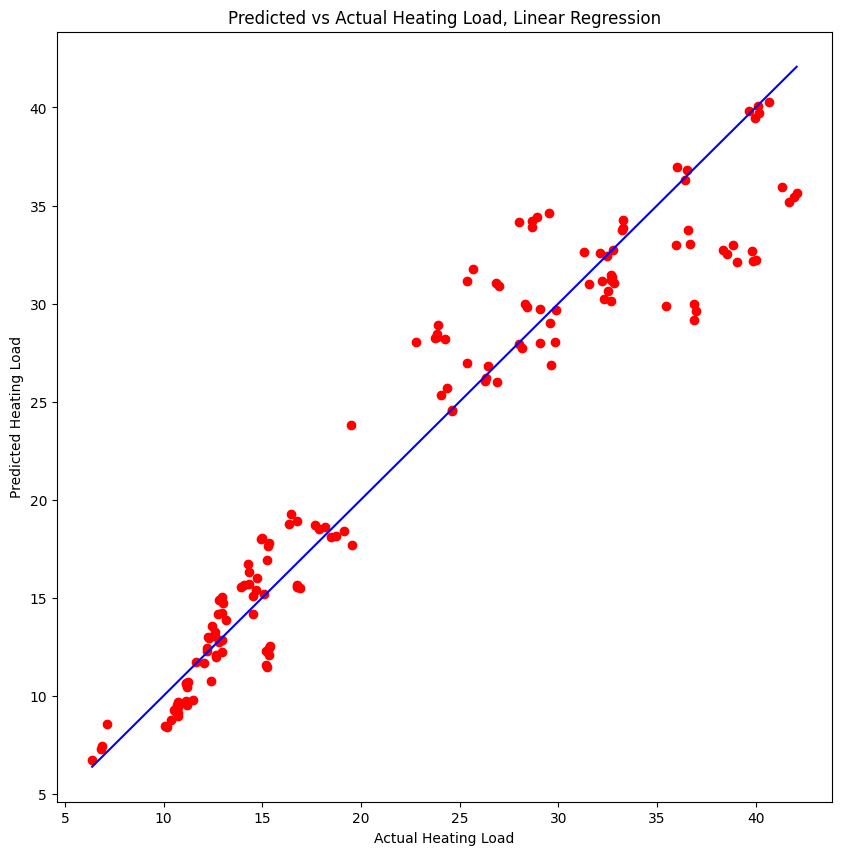

In [25]:
# Plot the predicted values against the actual values for the linear regression model. Add a 45 degree line to show the perfect prediction
plt.figure(figsize=(10, 10))
plt.scatter(y_test['Heating_Load'], y_pred, color='red')
plt.plot([y_test['Heating_Load'].min(), y_test['Heating_Load'].max()], [y_test['Heating_Load'].min(), y_test['Heating_Load'].max()], color='blue')
plt.title('Predicted vs Actual Heating Load, Linear Regression')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')

Text(0, 0.5, 'Predicted Heating Load')

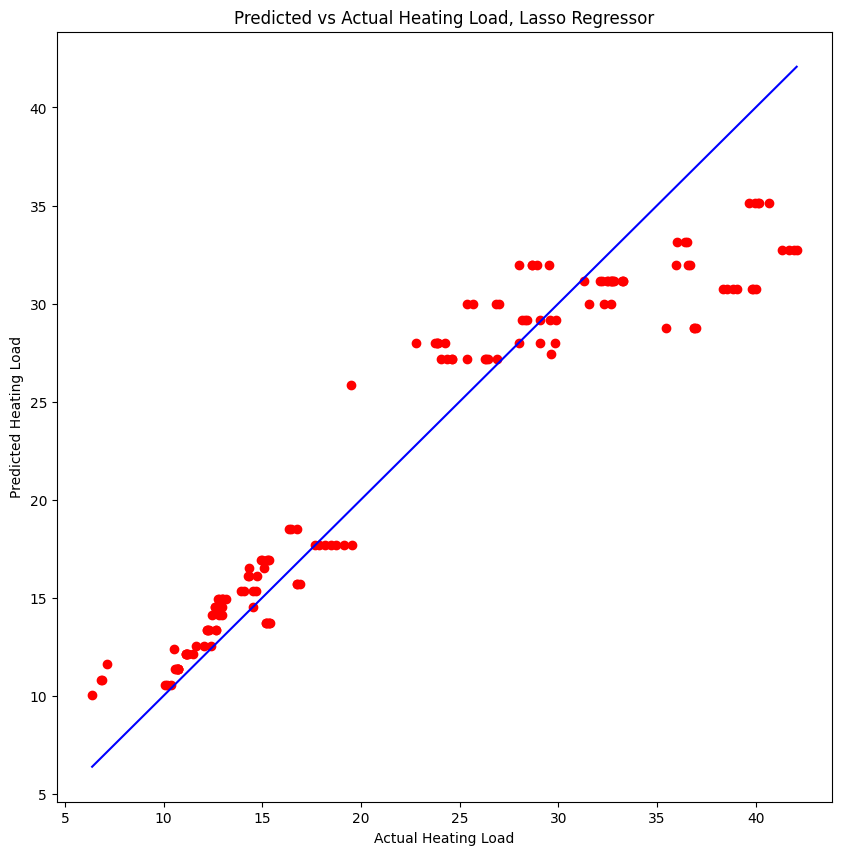

In [26]:
# Plot the predicted values against the actual values for the random Lasso regression model. Add a 45 degree line to show the perfect prediction
plt.figure(figsize=(10, 10))
plt.scatter(y_test['Heating_Load'], y_pred2, color='red')
plt.plot([y_test['Heating_Load'].min(), y_test['Heating_Load'].max()], [y_test['Heating_Load'].min(), y_test['Heating_Load'].max()], color='blue')
plt.title('Predicted vs Actual Heating Load, Lasso Regressor')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')

Text(0, 0.5, 'Predicted Heating Load')

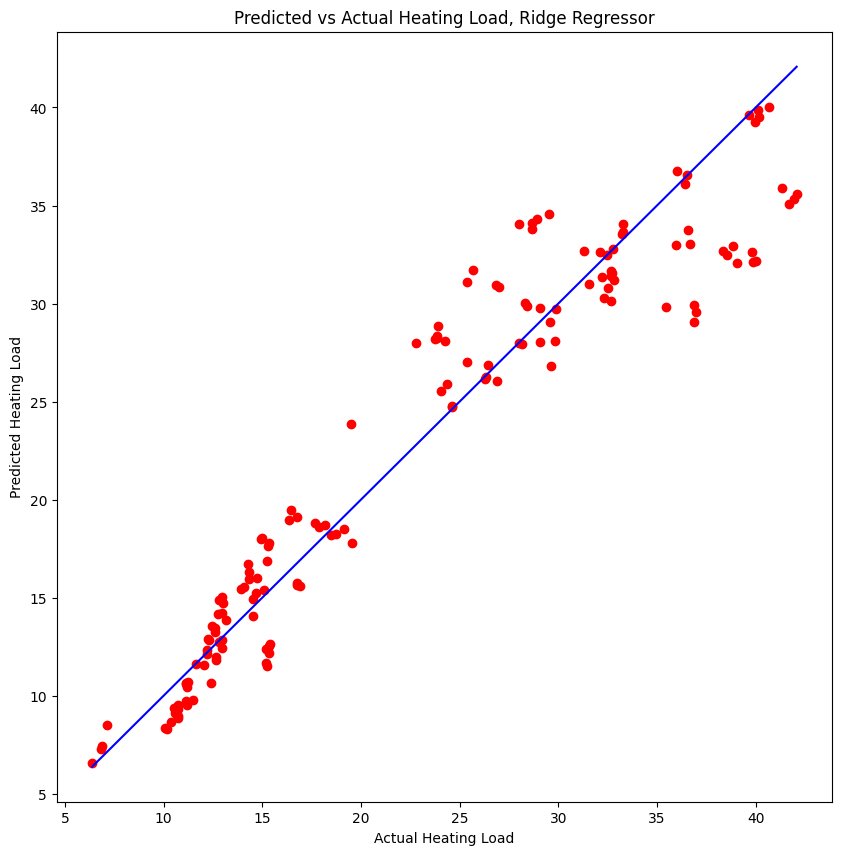

In [27]:
# Plot the predicted values against the actual values for the Ridge regression model. Add a 45 degree line to show the perfect prediction
plt.figure(figsize=(10, 10))
plt.scatter(y_test['Heating_Load'], y_pred3, color='red')
plt.plot([y_test['Heating_Load'].min(), y_test['Heating_Load'].max()], [y_test['Heating_Load'].min(), y_test['Heating_Load'].max()], color='blue')
plt.title('Predicted vs Actual Heating Load, Ridge Regressor')
plt.xlabel('Actual Heating Load')
plt.ylabel('Predicted Heating Load')

#### Caveat:
We need better strategies to estimate the error of our regressors. One such strategy can be to do repeated splits (user-defined variable), and to average the performance of the various regressors for each split.

This way we can evaluate framework fairly: multiple models, hyperparameter tuning, repeated random splits, and performance visualization.

In [28]:
# Adjustable for hyperparameter tuning

models = {
    "linear": (LinearRegression(), {'model__fit_intercept': [True, False]}),
    "lasso":  (Lasso(random_state=RSEED), {'model__alpha': np.logspace(-3, 3, 20)}),
    "ridge":  (Ridge(random_state=RSEED), {'model__alpha': np.logspace(-3, 3, 20)})
}


In [29]:
def evaluate_reg(output,metrics,n_splits,n_repeats=20,random_state=RSEED):
    '''
    Metrics:'MAE','R2', or'RMSE'
    Output: 'Heating_Load' or 'Cooling_Load'
    '''
    all_scores = []
    for name, (est, params) in models.items():
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', est)
        ])
        cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
        if metrics == 'MAE':
            scoring=make_scorer(mean_absolute_error, greater_is_better=False)
        elif metrics == 'R2':
            scoring='r2'
        elif metrics == 'RMSE':
            scoring='neg_root_mean_squared_error'  
        else:
            raise ValueError("Metric must be 'MAE', 'R2', or 'RMSE'")

        scores = cross_val_score(pipeline, X, y[output], cv=cv, scoring=scoring)
        # Adjust sign if needed
        if metrics in ['MAE', 'RMSE']:
            scores = -scores

        all_scores.append(pd.DataFrame({
            "Model": name,
            metrics: scores
        }))

    return pd.concat(all_scores, ignore_index=True)

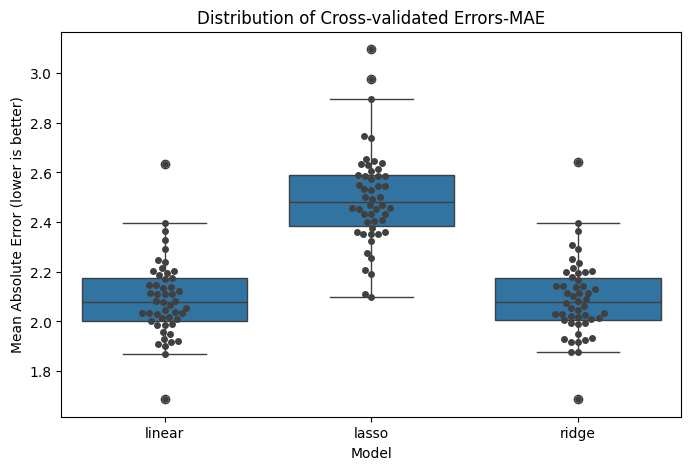

In [30]:
# MAE
df_mae= evaluate_reg(output='Heating_Load',metrics="MAE", n_splits=5, n_repeats=10)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_mae, x="Model", y="MAE")
sns.swarmplot(data=df_mae, x="Model", y="MAE", color=".25")  # show individual points
plt.ylabel("Mean Absolute Error (lower is better)")
plt.title("Distribution of Cross-validated Errors-MAE")
plt.show()

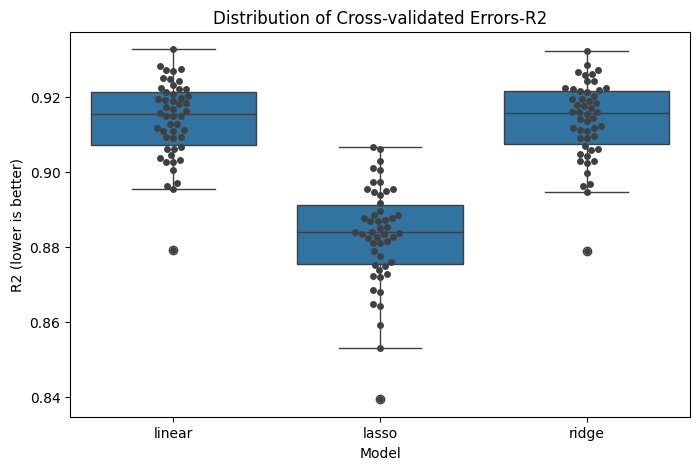

In [31]:
# R2
df_r2= evaluate_reg(output='Heating_Load',metrics="R2", n_splits=5, n_repeats=10)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_r2, x="Model", y="R2")
sns.swarmplot(data=df_r2, x="Model", y="R2", color=".25")  # show individual points
plt.ylabel("R2 (lower is better)")
plt.title("Distribution of Cross-validated Errors-R2")
plt.show()

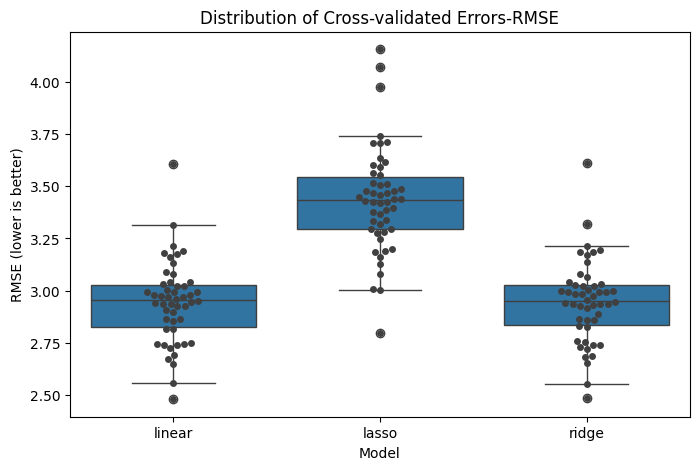

In [32]:
# RMSE
df_rmse= evaluate_reg(output='Heating_Load',metrics="RMSE", n_splits=5, n_repeats=10)

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_rmse, x="Model", y="RMSE")
sns.swarmplot(data=df_rmse, x="Model", y="RMSE", color=".25")  # show individual points
plt.ylabel("RMSE (lower is better)")
plt.title("Distribution of Cross-validated Errors-RMSE")
plt.show()

# The End